In [11]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv("/Users/keshavgattani/Desktop/MSBA/spring/social_media/Final Project/Combined_Craigslist_Reviews.csv")  # Adjust path/column as needed

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df["cleaned_review"] = df["review"].apply(clean_text)
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/keshavgattani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/keshavgattani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keshavgattani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,review,type,cleaned_review
0,comment,"Any message asking you to access or check ""cra...",main comment,message asking access check craigslist voicema...
1,comment,If you're using Windows XP with Internet Explo...,main comment,youre using window xp internet explorer able p...
2,comment,If you've got a non-craigslist-related questio...,main comment,youve got noncraigslistrelated question life g...
3,comment,We have received reports of the reply button n...,main comment,received report reply button displaying popup ...
4,comment,craigslist does not have banner or display ads...,main comment,craigslist banner display ad kind see ad compu...


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/keshavgattani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


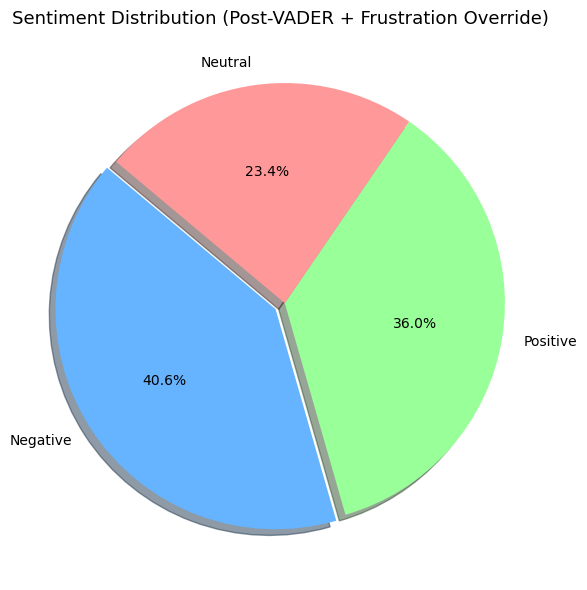

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Define frustration keywords
frustration_keywords = [
    'blocked', 'deleted', 'flag', 'issue', 'problem', 'remove', 'not working',
    'doesn’t', 'won’t', 'error', 'glitch', 'hidden', 'disappear', 'moderated',
    'confused', 'frustrated', 'angry', 'lost', 'cannot', 'can’t'
]

# Scoring function with frustration override
def get_sentiment_with_override(text):
    score = sid.polarity_scores(text)['compound']
    lower_text = str(text).lower()
    has_frustration = any(kw in lower_text for kw in frustration_keywords)
    
    if score >= 0.2:
        return 'Negative' if has_frustration else 'Positive'
    elif score <= -0.2:
        return 'Negative'
    else:
        return 'Negative' if has_frustration else 'Neutral'

# Apply to DataFrame
df['sentiment'] = df['cleaned_review'].apply(get_sentiment_with_override)
df[['cleaned_review', 'sentiment']].head()

# Count sentiment labels
sentiment_counts = df['sentiment'].value_counts()

# Pie chart parameters
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#66b3ff', '#99ff99', '#ff9999']  # Neutral, Positive, Negative
explode = [0.05 if label == 'Negative' else 0 for label in labels]  # Slightly pull out 'Negative' for emphasis

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
)
plt.title('Sentiment Distribution (Post-VADER + Frustration Override)', fontsize=13)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()

In [13]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Tokenize cleaned reviews
tokenized_docs = [text.split() for text in df['cleaned_review']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Show topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.030*"ad" + 0.016*"included" + 0.016*"posting" + 0.009*"posted" + 0.006*"make"')
(1, '0.022*"ad" + 0.009*"cl" + 0.008*"posting" + 0.007*"site" + 0.007*"day"')
(2, '0.023*"ad" + 0.010*"craigslist" + 0.009*"post" + 0.009*"many" + 0.009*"site"')
(3, '0.035*"hide" + 0.012*"post" + 0.012*"get" + 0.011*"email" + 0.010*"love"')
(4, '0.026*"ad" + 0.015*"email" + 0.012*"help" + 0.011*"forum" + 0.010*"post"')


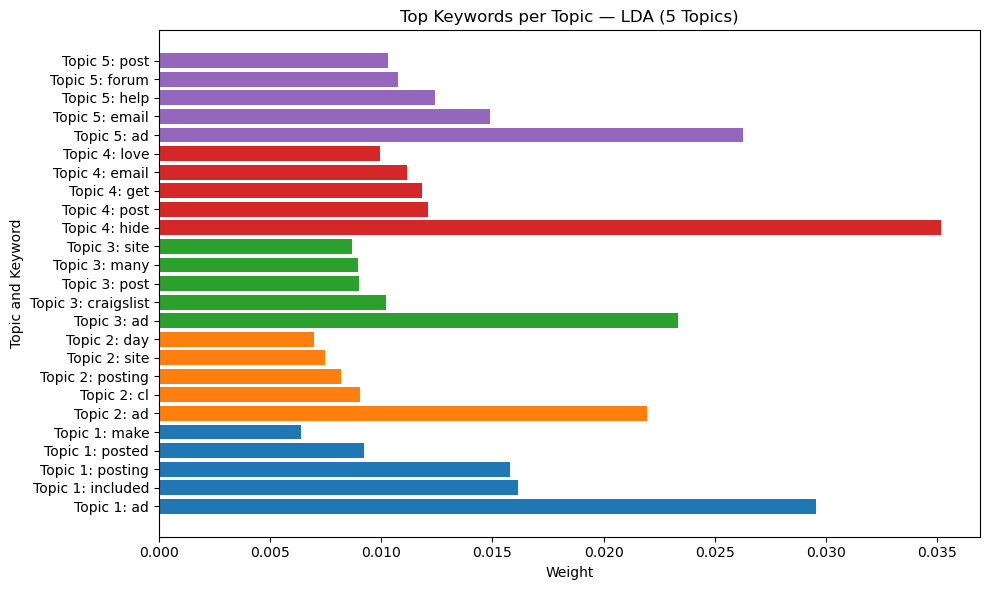

In [14]:
# Extract and parse topics
topic_words = []
for topic_id, topic in lda_model.show_topics(num_topics=5, num_words=5, formatted=False):
    for word, weight in topic:
        topic_words.append({
            'Topic': f'Topic {topic_id + 1}',
            'Keyword': word,
            'Weight': weight
        })

# Create DataFrame
df_topics = pd.DataFrame(topic_words)

# Plot: Horizontal bar chart
plt.figure(figsize=(10, 6))
for i, topic in enumerate(df_topics['Topic'].unique()):
    subset = df_topics[df_topics['Topic'] == topic]
    plt.barh([f'{topic}: {kw}' for kw in subset['Keyword']], subset['Weight'])

plt.title('Top Keywords per Topic — LDA (5 Topics)')
plt.xlabel('Weight')
plt.ylabel('Topic and Keyword')
plt.tight_layout()
plt.show()

In [15]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

# # Create pyLDAvis visualization
# pyLDAvis.enable_notebook()  # or skip this line if running outside Jupyter
# lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(lda_display)

Silhouette Score: 0.07


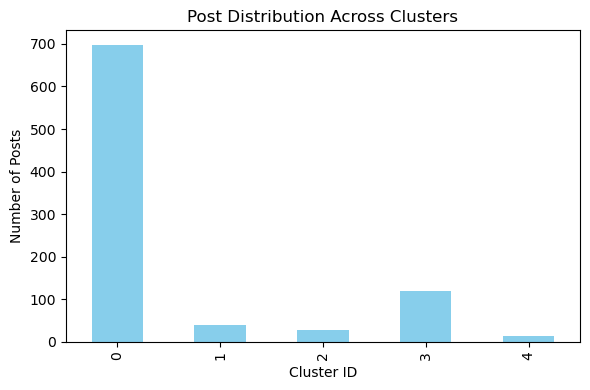

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
X_tfidf = vectorizer.fit_transform(df['cleaned_review'])

# KMeans clustering
k = 5  # or use elbow method to decide
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Evaluate clustering
score = silhouette_score(X_tfidf, df['cluster'])
print("Silhouette Score:", round(score, 2))
df[['cleaned_review', 'cluster']].head()

cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Post Distribution Across Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()


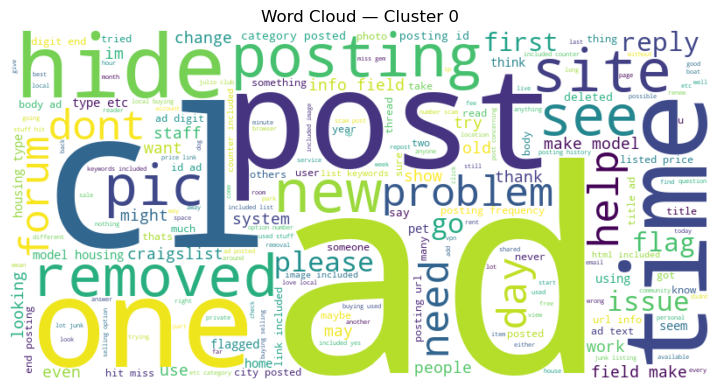

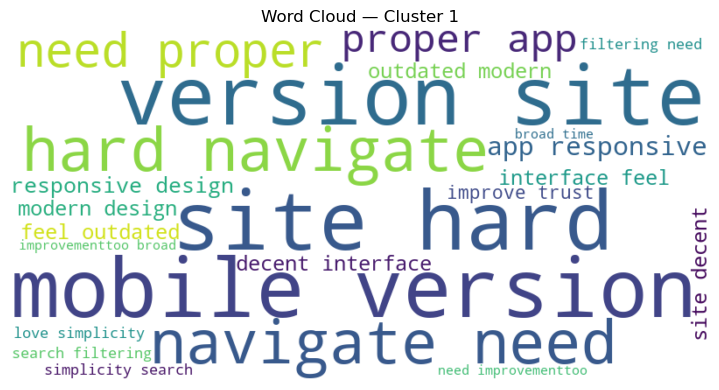

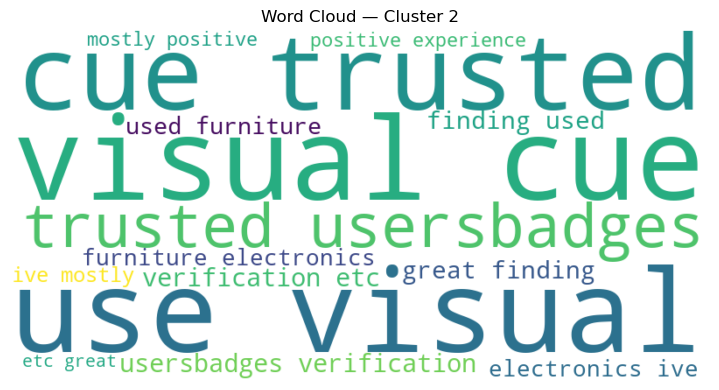

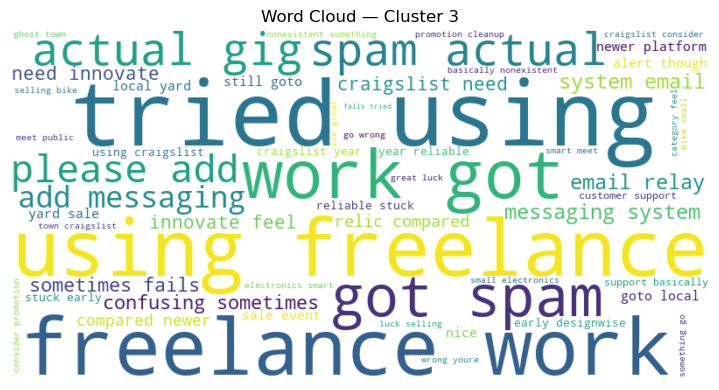

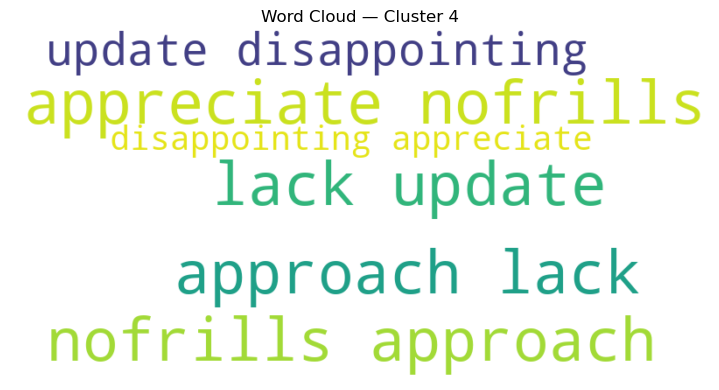

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for each cluster
for i in range(k):
    cluster_text = " ".join(df[df['cluster'] == i]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud — Cluster {i}")
    plt.tight_layout()
    plt.show()


✅ Total Explained Variance by 100 components: 0.5983


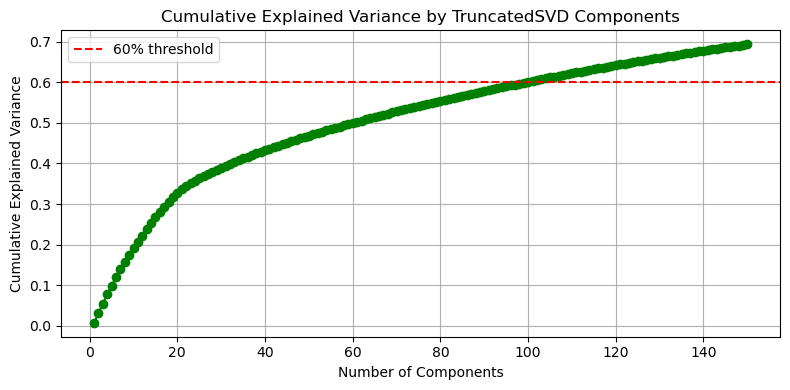

In [18]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define number of components (can tune this later based on explained variance)
n_components = 100  # start with 100 components

# Apply Truncated SVD
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Check explained variance
explained = svd.explained_variance_ratio_.sum()
print(f"✅ Total Explained Variance by {n_components} components: {explained:.4f}")

# Try a range of components
n_range = 150
svd_temp = TruncatedSVD(n_components=n_range, random_state=42)
X_reduced_temp = svd_temp.fit_transform(X_tfidf)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(svd_temp.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_range + 1), cumulative_variance, marker='o', linestyle='--', color='green')
plt.axhline(y=0.6, color='red', linestyle='--', label='60% threshold')
plt.title('Cumulative Explained Variance by TruncatedSVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
from sklearn.model_selection import train_test_split

# Define features and target
X = X_reduced
y = df['sentiment']  # should be 'Positive', 'Neutral', or 'Negative'

# Train–test split (stratify to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data split complete.")
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


✅ Data split complete.
Training samples: 720
Test samples: 180


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logit = LogisticRegression(max_iter=1000, random_state=42)
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)

acc_logit = accuracy_score(y_test, y_pred_logit)
print("🔹 Logistic Regression Accuracy:", round(acc_logit * 100, 2), "%")


🔹 Logistic Regression Accuracy: 72.78 %


In [21]:
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB expects non-negative input (TF-IDF is fine, SVD output is too)
# We switch to GaussianNB for dense real-valued input like after TruncatedSVD
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
print("🔹 Naive Bayes Accuracy:", round(acc_nb * 100, 2), "%")


🔹 Naive Bayes Accuracy: 62.22 %


In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("🔹 SVM Accuracy:", round(acc_svm * 100, 2), "%")


🔹 SVM Accuracy: 73.89 %


In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
print("🔹 Decision Tree Accuracy:", round(acc_dt * 100, 2), "%")


🔹 Decision Tree Accuracy: 63.33 %


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("🔹 Random Forest Accuracy:", round(acc_rf * 100, 2), "%")


🔹 Random Forest Accuracy: 73.89 %


In [25]:
import pandas as pd

# Collect all accuracy scores
results = {
    "Model": ["Logistic Regression", "Naive Bayes", "SVM", "Decision Tree", "Random Forest"],
    "Accuracy": [
        round(acc_logit * 100, 2),
        round(acc_nb * 100, 2),
        round(acc_svm * 100, 2),
        round(acc_dt * 100, 2),
        round(acc_rf * 100, 2),
    ]
}

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print("📊 Model Accuracy Comparison")
display(results_df)


📊 Model Accuracy Comparison


,Model,Accuracy
0,SVM,73.89
1,Random Forest,73.89
2,Logistic Regression,72.78
3,Decision Tree,63.33
4,Naive Bayes,62.22


🔍 Classification Report — Random Forest
              precision    recall  f1-score   support

    Negative       0.62      0.96      0.76        73
     Neutral       1.00      0.55      0.71        42
    Positive       0.89      0.62      0.73        65

    accuracy                           0.74       180
   macro avg       0.84      0.71      0.73       180
weighted avg       0.81      0.74      0.73       180



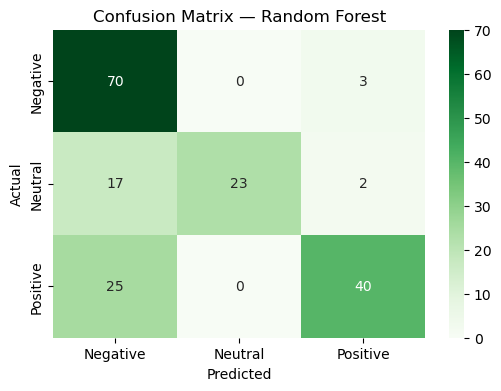

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# RANDOM FOREST
print("🔍 Classification Report — Random Forest")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 Classification Report — SVM
              precision    recall  f1-score   support

    Negative       0.66      0.89      0.76        73
     Neutral       0.85      0.52      0.65        42
    Positive       0.84      0.71      0.77        65

    accuracy                           0.74       180
   macro avg       0.78      0.71      0.72       180
weighted avg       0.77      0.74      0.73       180



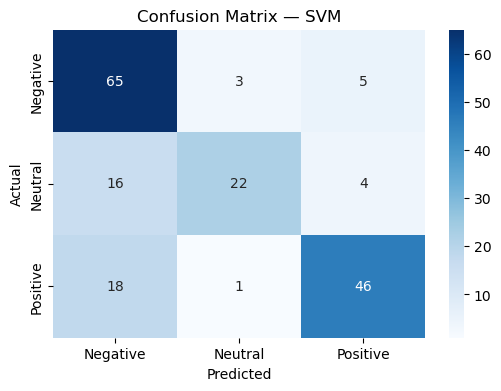

In [27]:
# SVM
print("🔍 Classification Report — SVM")
print(classification_report(y_test, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("Confusion Matrix — SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 Classification Report — Logistic Regression
              precision    recall  f1-score   support

    Negative       0.69      0.88      0.77        73
     Neutral       0.78      0.50      0.61        42
    Positive       0.77      0.71      0.74        65

    accuracy                           0.73       180
   macro avg       0.74      0.69      0.71       180
weighted avg       0.74      0.73      0.72       180



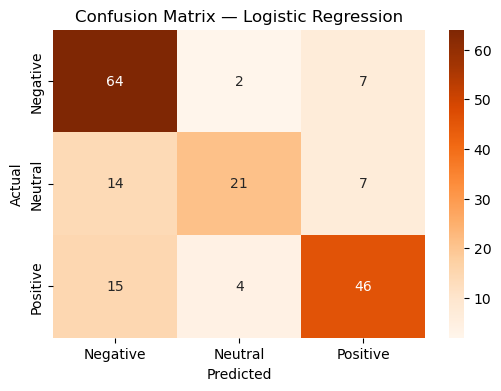

In [28]:
# LOGISTIC REGRESSION
print("🔍 Classification Report — Logistic Regression")
print(classification_report(y_test, y_pred_logit))

conf_matrix_logit = confusion_matrix(y_test, y_pred_logit)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_logit, annot=True, fmt='d', cmap='Oranges', xticklabels=logit.classes_, yticklabels=logit.classes_)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [29]:
from sklearn.ensemble import VotingClassifier

# Hard Voting: majority class prediction
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('svm', svm),
        ('logit', logit)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
acc_vote = accuracy_score(y_test, y_pred_vote)
print("🔸 Voting Ensemble Accuracy:", round(acc_vote * 100, 2), "%")


🔸 Voting Ensemble Accuracy: 74.44 %


🔍 Classification Report — Voting Ensemble
              precision    recall  f1-score   support

    Negative       0.66      0.92      0.77        73
     Neutral       0.88      0.55      0.68        42
    Positive       0.85      0.68      0.75        65

    accuracy                           0.74       180
   macro avg       0.80      0.71      0.73       180
weighted avg       0.78      0.74      0.74       180



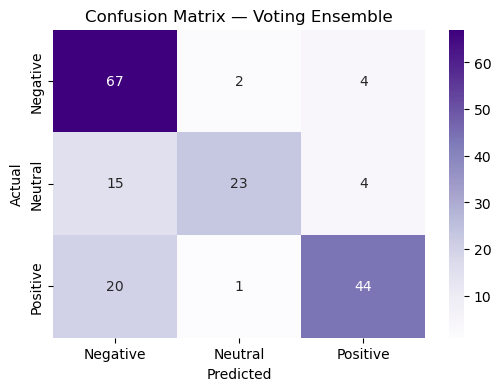

In [30]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("🔍 Classification Report — Voting Ensemble")
print(classification_report(y_test, y_pred_vote))

# Confusion matrix
conf_matrix_vote = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_vote, annot=True, fmt='d', cmap='Purples', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title("Confusion Matrix — Voting Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [31]:
import joblib
joblib.dump(voting_clf, "final_voting_model.pkl")

['final_voting_model.pkl']

In [32]:
import joblib
joblib.dump(rf, "rf_model.pkl")

['rf_model.pkl']

In [33]:
import joblib
joblib.dump(logit, "logit_model.pkl")

['logit_model.pkl']